In [99]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold

In [100]:
df = pd.read_csv('https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv')

In [101]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1462 entries, 0 to 1461
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   lead_source               1334 non-null   object 
 1   industry                  1328 non-null   object 
 2   number_of_courses_viewed  1462 non-null   int64  
 3   annual_income             1281 non-null   float64
 4   employment_status         1362 non-null   object 
 5   location                  1399 non-null   object 
 6   interaction_count         1462 non-null   int64  
 7   lead_score                1462 non-null   float64
 8   converted                 1462 non-null   int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 102.9+ KB


In [102]:
categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

numerical_columns = ['number_of_courses_viewed', 'annual_income', 'interaction_count', 'lead_score',]

In [103]:
for c in categorical_columns:
    df[c] = df[c].fillna('NA')

In [104]:
for n in numerical_columns:
    df[n] = df[n].fillna(0)

In [105]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)
 
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
 
y_train = df_train.converted.values
y_val = df_val.converted.values
y_test = df_test.converted.values
 
del df_train['converted']
del df_val['converted']
del df_test['converted'] 

### Question 1

In [106]:
scores = {}
for col in numerical_columns:
    score = roc_auc_score(y_train, df_train[col])
    if score < 0.5:
        score = 1 - score
    scores[col] = round(score, 3)
    print(f"AUC for {col}: {scores[col]}")

print("\nScores:", scores)

AUC for number_of_courses_viewed: 0.764
AUC for annual_income: 0.552
AUC for interaction_count: 0.738
AUC for lead_score: 0.614

Scores: {'number_of_courses_viewed': 0.764, 'annual_income': 0.552, 'interaction_count': 0.738, 'lead_score': 0.614}


### Question 2

In [107]:
features = categorical_columns + numerical_columns

dv = DictVectorizer(sparse=False)
train_dict = df_train[features].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val[features].to_dict(orient='records')
X_val = dv.transform(val_dict)


model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)


y_pred = model.predict_proba(X_val)[:, 1]


auc = roc_auc_score(y_val, y_pred)
print(f"Model AUC: {round(auc, 3)}")

Model AUC: 0.817


### Question 3

In [108]:
scores = []

thresholds = np.linspace(0,1,100)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)

    predict_positive = (y_pred >=t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()

    scores.append((t,tp,fp,fn,tn))

In [109]:
columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns=columns)

df_scores['precision'] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores['recall'] = df_scores.tp / (df_scores.tp + df_scores.fn)

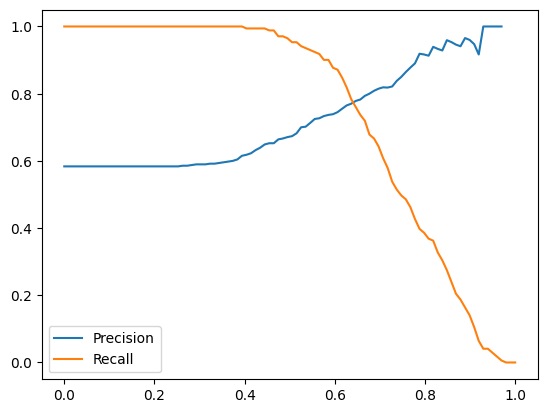

In [110]:
plt.plot(df_scores.threshold, df_scores['precision'], label='Precision')
plt.plot(df_scores.threshold, df_scores['recall'], label='Recall')
plt.legend()

In [111]:
diff = np.abs(df_scores['precision'] - df_scores['recall'])
idx = diff.idxmin() 

threshold_intersect = df_scores.loc[idx, 'threshold']
print(f"Precision and recall intersect at threshold {threshold_intersect:.3f}")

Precision and recall intersect at threshold 0.636


### Question 4

In [112]:
df_scores["f1"] = 2*(df_scores["precision"]*df_scores["recall"])/(df_scores["precision"] + df_scores["recall"])

idx_max = df_scores["f1"].idxmax()
threshold_f1_max = df_scores.loc[idx_max, "threshold"]
f1_max = df_scores.loc[idx_max, "f1"]

print(f"max F1 = {f1_max:.2f} at threshold {threshold_f1_max:.2f}.")

max F1 = 0.81 at threshold 0.56.


### Question 5

In [113]:
def train(df_train, y_train, C):
    dicts = df_train[categorical_columns + numerical_columns].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

def predict(df, dv, model):
    dicts = df[categorical_columns + numerical_columns].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [114]:
def cross_validate(C=1.0):
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)
    
    scores = []
    
    for train_idx, val_idx in kfold.split(df_full_train):
        
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]
    
        y_train = df_train.converted.values
        y_val = df_val.converted.values
    
        dv, model = train(df_train, y_train, C)
        y_pred = predict(df_val, dv, model)
    
        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)
    return np.mean(scores), np.std(scores)

In [115]:
mean, std = cross_validate()
print(f"std: {round(std,3)}")

std: 0.036


### Question 6

In [116]:
from tqdm.auto import tqdm
n_splits = 5

for C in tqdm([0.000001, 0.001, 1]):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.converted.values
        y_val = df_val.converted.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

  0%|          | 0/3 [00:00<?, ?it/s]

C=1e-06 0.560 +- 0.024
C=0.001 0.867 +- 0.029
C=1 0.822 +- 0.036
